<a href="https://colab.research.google.com/github/rsadaphule/jhu-dnn/blob/main/Group_10_10%F0%9F%8F%86%F0%9F%93%88Crypto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>📈Crypto</font>](https://www.kaggle.com/competitions/27mar23-crypto/rules)**. [**Instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running Colabs.

<small>**(Optional) CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is optional and this decision will not affect our grade in any way. <font color=gray><i>(If ok with sharing your Colab for educational purposes, leave "X" in the check box.)</i></font></small>

In [ ]:
from google.colab import drive; drive.mount('/content/drive')       # OK to enable, if kaggle.json is stored in Google Drive

Mounted at /content/drive


In [ ]:
# !pip -q install tensorflow==2.8 > log
# !apt -q install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 >> log
!pip -q install -U tfds-nightly tensorflow_addons tensorflow >> log

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydantic 2.1.1 requires typing-extensions>=4.6.1, but you have typing-extensions 4.5.0 which is incompatible.
pydantic-core 2.4.0 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.


In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                                 # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log   # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log                         # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                                    # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 7aug23jh-crypto                # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                                # download competition dataset as a zip file
!unzip -o *.zip >> log                                              # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                             # print public leaderboard

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: 7aug23jh-crypto
100% 5.94M/5.94M [00:01<00:00, 4.05MB/s]
Using competition: 7aug23jh-crypto
  teamId  teamName         submissionDate       score    
--------  ---------------  -------------------  -------  
10776446  Group 10         2023-08-14 00:10:56  0.68166  
10775914  Group 14         2023-08-13 23:27:06  0.65428  
10776682  Group 3          2023-08-13 21:28:33  0.58090  
10776727  Group 9          2023-08-13 23:08:37  0.54088  
10778350  Group 04         2023-08-13 17:04:59  0.50166  
10779902  Group 15         2023-08-13 01:22:20  0.46565  
10775603  Group 5          2023-08-13 19:29:43  0.37972  
10783445  Group 2          2023-08-14 00:07:42  0.17871  
10775010  Group 1          2023-08-13 21:02:28  0.17618  
10776654  Group 11         2023-08-13 00:00:51  0.17121  
10779048  Group 13         2023-08-13 16:44:17  0.17002  
10775732  Group 8          2023-08-13 19:32:25  0.16366  
10776010  

See [more](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) about NVIDIA GPU stats. Test your code in (free) Colab. It uses Tesla K80 GPU.

In [ ]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
Tesla T4, 15360 MiB, 15101 MiB, 0 MiB


In [ ]:
!pip -q install -U tensorflow_addons > log   # update tfa in case students need to use it

In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
import tensorflow_addons as tfa, tensorflow as tf, tensorflow.keras as keras, tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, RNN, LSTM, TimeDistributed
os.environ['TF_DETERMINISTIC_OPS'] = '1'; os.environ['TF_CUDNN_DETERMINISTIC'] = '1'; # allows seeding RNG on GPU
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 4.26 s, sys: 444 ms, total: 4.7 s
Wall time: 5.24 s


Your training data are 7 descriptive features for past 500K observations. See helpful [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition).

In [ ]:
tXY = pd.read_csv('tXY.csv', index_col='id'); tXY

,Count,Open,High,Low,Close,Volume,VWAP
id,,,,,,,
0,64,0.20,0.20,0.20,0.20,447,0.20
1,72,0.20,0.20,0.20,0.20,592,0.20
...,...,...,...,...,...,...,...
499998,1636,1.15,1.16,1.15,1.15,2615,1.15
499999,3228,1.13,1.14,1.12,1.13,3354,1.13


Your task is to forecast the closing price for all future time steps (index IDs below).

In [ ]:
pY = pd.read_csv('sampleSubmission.csv', index_col='id'); pY.T

id,500000,500001,500002,500003,500004,500005,500006,500007,500008,500009,...,524421,524422,524423,524424,524425,524426,524427,524428,524429,524430
Close,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 300 sec. Good luck!


<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer Start Here...</font></strong>


# Documentation
**Group 10 members:**
- Brian Yang
- Jing Qian
- Michael Omelchenko
- Mit Patel

# **Preprocessing Approach**

**TODO. Explain your preprocessing:** i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.

## I. Exploratory Data Analysis (EDA)

- We did not find any missing data in the dataset.

- Many papers indicate that there isn't an effective tool for predicting financial prices like stock prices for profit. Improving generalization ability for stock market prediction is still an important area that remains unresolved[8]. The #2 winner from the G-Research Crypto Forecasting[2] admits that "It didn't end up being profitable long-term as a single DIY investor."[3] Therefore, our focus will be on identifying trends and understand the Pearson correlation coefficient rather than precise prices.

- The #2 winner of the G-Research Crypto Forecasting[2] indicated a 60% likelihood of dropping, while Meme Lord Capital expected a 75% chance of retaining his place. This reminds us of the well-known "No Free Lunch Theorems for Optimization"[7] and indicates to us to balance the score and generalization. Although linear regression is not a allowed model according to the rules, we adopted it as our baseline to investigate this problem.

**Training Dataset Overview** <br>
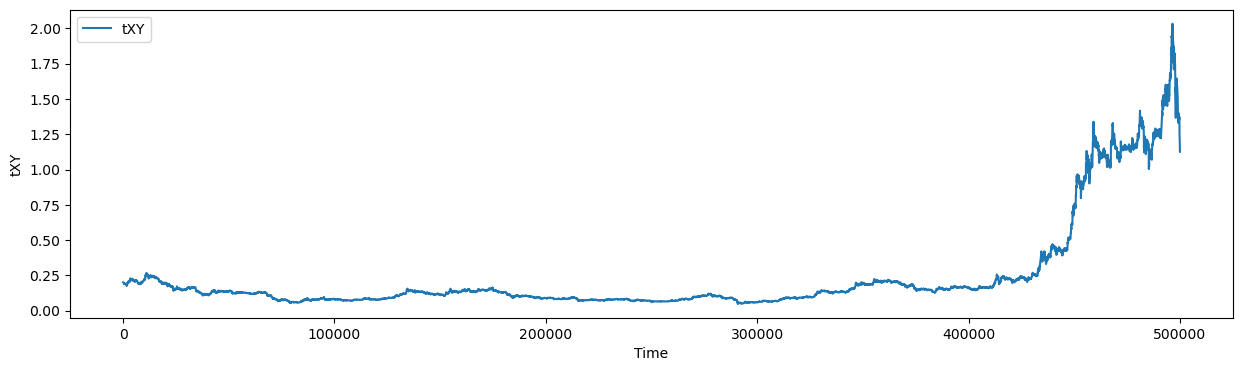

## II. Feature Engineering

- Inspired by the features from the #3 solutions[4] of the G-Research Crypto Forecasting[2] competition. Also, we replicate the key features which improve **MSE Loss** on the starter model, so we adopted them.

- Utilized the `reduce_mem_usage` function from the #3 solution[4] to decrease the training dataset's size without loss of information which we employed in our experiments before sampling. Later on, we abandoned it.

- Applied `librosa`[6] for resampling.

- Implemented min-max scaling to enhance model convergence.

- What we should explore in the future:

  - We later recognized the potential benefits of mean-related features and indicators. While we've already integrated four features from the #3 notebook, this isn't currently our top priority.

  - Since we are only interested in the change of the price, especially the one above and below the average, we should develop more features in price delta instead of price itself.

  - Incorporating general financial market indicators like `MACD`, `RSI`, `Bollinger Bands`, etc.

  - Further investigate the top solutions from the G-Research Crypto Forecasting[2]

In [ ]:
import librosa
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set Macro
sample_length = 1000 # samples per block
train_length = len(tXY)
pred_length = len(pY)

num_train = train_length // sample_length
num_pred = pred_length // sample_length + 2

pY_dense = pY[:num_pred].reset_index(drop=True)
pY_dense.index += num_train

In [ ]:
# Sample down
tXY_sample = librosa.resample(tXY['Close'].to_numpy(), orig_sr=len(tXY), target_sr=num_train)

In [ ]:
# Features from #3 solution[4]
lags = [7, 21, 49]

tXY_sample = pd.DataFrame(tXY_sample, columns=['Close'])

for lag in lags:
    tXY_sample[f'log_close/mean_{lag}'] = np.log(np.array(tXY_sample[f'Close']) / np.roll(np.append(np.convolve(np.array(tXY_sample[f'Close']), np.ones(lag)/lag, mode="valid"), np.ones(lag - 1)), lag - 1))
    tXY_sample[f'log_return_{lag}'] = np.log(np.array(tXY_sample[f'Close']) / np.roll(np.array(tXY_sample[f'Close']), lag))
    tXY_sample[f'mean_close/mean_{lag}'] = np.mean(tXY_sample.iloc[:,tXY_sample.columns.str.startswith(f'log_close/mean_{lag}')], axis=1)
    tXY_sample[f'mean_log_returns_{lag}'] = np.mean(tXY_sample.iloc[:,tXY_sample.columns.str.startswith(f'log_return_{lag}')], axis=1)

## III. Data Scaling

* Min-Max Scaling is applied to stock price datasets before model training to transform the data into a consistent range, typically between 0 and 1. This preprocessing step is crucial because stock prices often have varying scales which can cause issues for machine learning algorithms. Scaling ensures that all features contribute equally to the model's learning process, aids in optimization convergence, prevents dominance of certain features and maintains meaningful distances between data points in order to resulting in more effective and reliable model training and interpretation.

In [ ]:
# Min max scalar
MIN = np.min(tXY_sample['Close'])
MAX = np.max(tXY_sample['Close'])
tXY = tXY_sample
tXY['Close'] = (tXY['Close'] - MIN)/(MAX-MIN)

# **Modeling Approach**

**TODO. Explain your modeling approach:** ideas you tried and why you thought they would be helpful. Takeaway: how these decisions guided you in modeling.

## IV. Modeling

- Referring to the G-Research Crypto Forecasting 2nd place solution[3], it suggests to conduct multiple rounds of tests and monitor the CV variance to ensure the performance boost is not introduced by noise. For the early experiments for which we did not require a GPU, we adopted the standardized testing approach shown below. We also leverage public leaderboard scores as our reference.

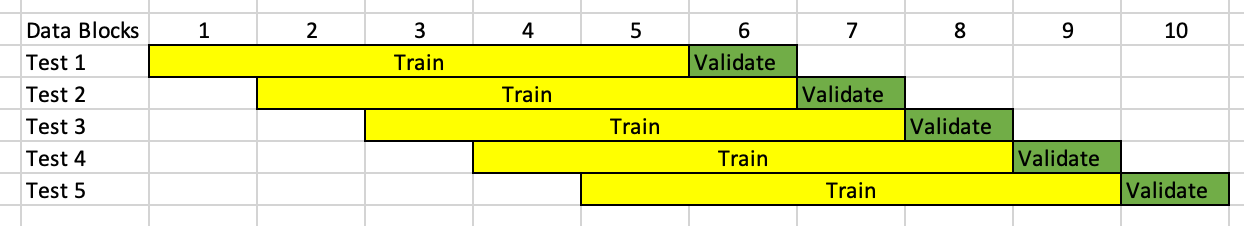

- Following unfortunate events such as system crash and Google's access restrictions to GPU, we implemented a low computational testing approach by monitoring multiple Pearson correlation coefficients. This might not be a good general idea but it seemed to work for this problem with the exception of possible overfitting.

- Linear regression shows promising performance (0.46948) on the public leaderboard. However, further analysis demonstrated this method lacks stability. We divided the test dataset into blocks of 24431 in length and utilized linear regression on training data (5-14 leading blocks) to predict the subsequent block. The result shows it has a 40-67% chance of surpassing the baseline score of 0.13056, with very high STD (0.7+) among the Pearson correlation coefficient[5] result.

- While employing more than 15 leading blocks for linear regression might lead to better training results, we can only run less than 5 tests which lower the confidence. Therefore, we have decided not to pursue this strategy due to its instability.  


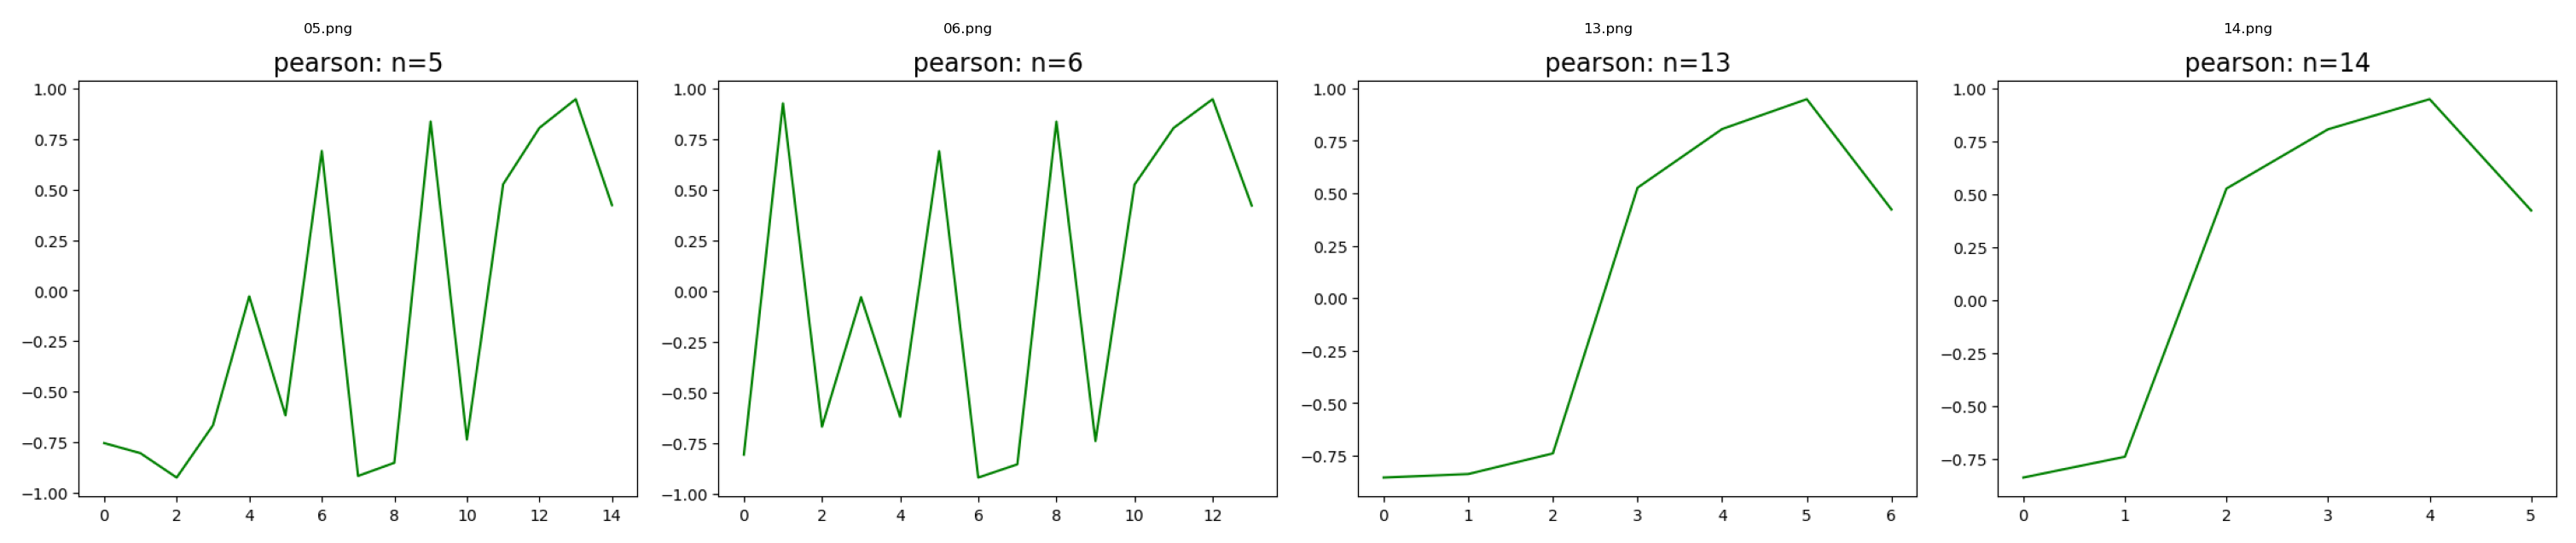

- We experimented by fitting the curve with two lines. Below you can find an example by using `tXY[200000: 400000]`. The first image shows a Pearson correlation coefficient as 0.775 between the linear regression line and the true label. In the second/third images, after splitting the data in half and calculating separately, we obtained values of 0.039 and 0.731. The fourth image, using two lines, yielded a Pearson value of 0.857, which is an improvement over the first image. While in some cases (`tXY[230000, 290000]`for example) we may find better scores in the second/third images, the two-line fit consistently returns higher scores than the first image. This experiment helps us better understand  Pearson correlation coefficient, but since we lack the true label for our predictions, it is not practically implementable.

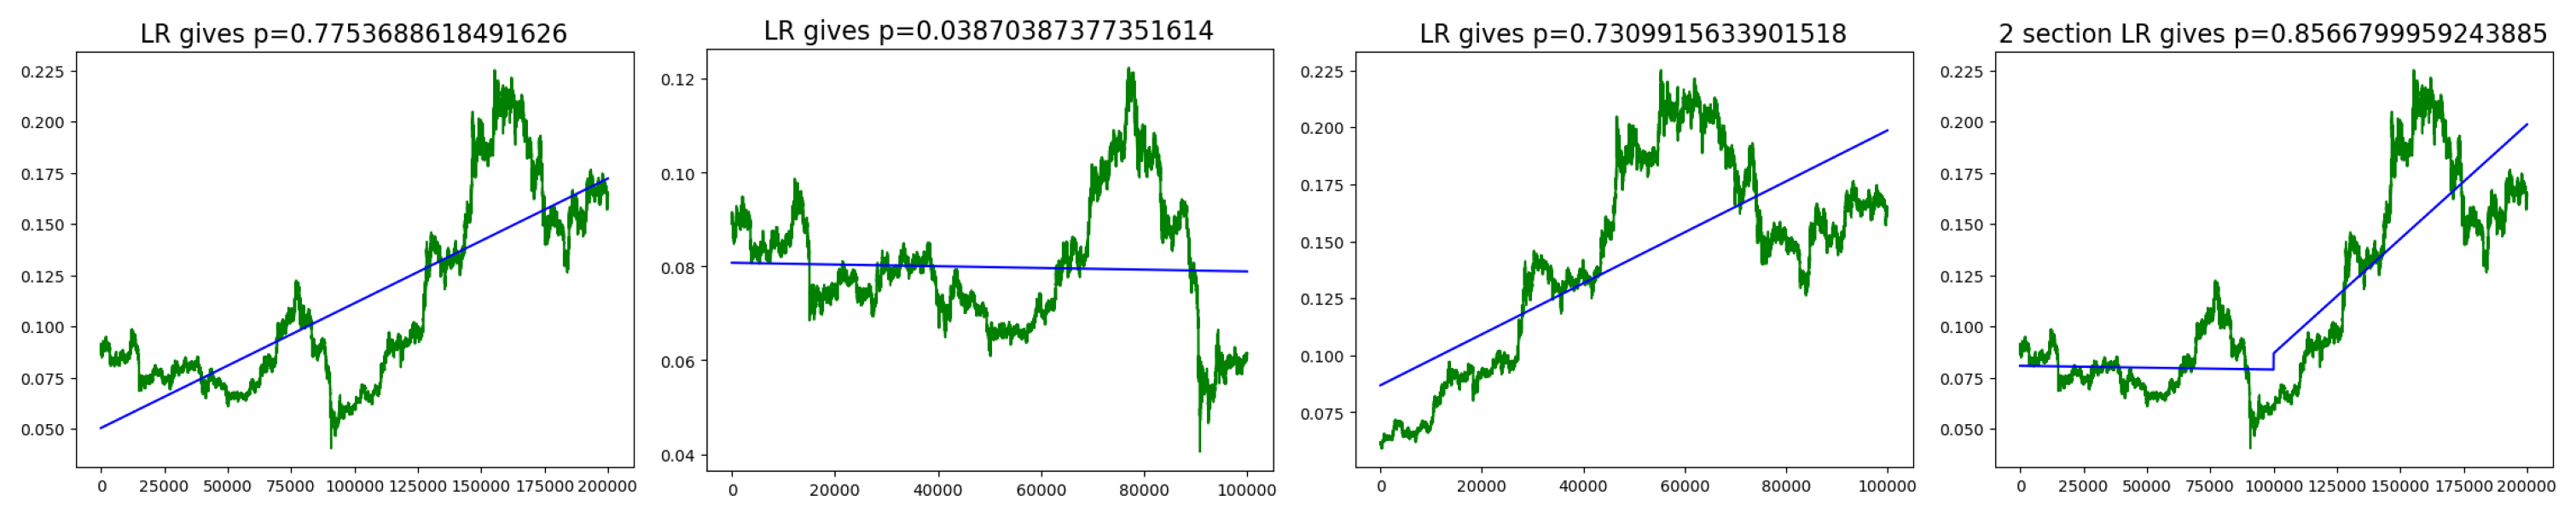

- We naturally divided the data into blocks, utilizing the final data point as a sample point for this block. This approach significantly reduced the dataset size, allowing us to execute the model with the full dataset. However, the outcome of 0.11108 on the leaderboard was unexpected. It appears that selecting the last data point introduced excessive randomness and noise. This approximation did not prove to be a suitable successor to the previous experiment. Below is the image of comparing the curve shape of three predictions.

- Recalling our lessons from Week 3🏆👂Phonemes, we leverage librosa.resample for downsampling. Testing shows a remarkably high (0.9993) Pearson correlation coefficient between the downsampled and sample_block(last data point) dataset. And the shape of the curve is very close to the full tXY graphic shown in the begining. Fortunately, librosa.resample also offers upsampling for expanding predictions.

- Given that LSTM might not perform well with predictions exceeding 100 data points as per our textbook (page 520), down-sampling and prediction of 25-50 data points might give good estimation of the price curve, and this combination appears to be a promising solution for this week's problem.

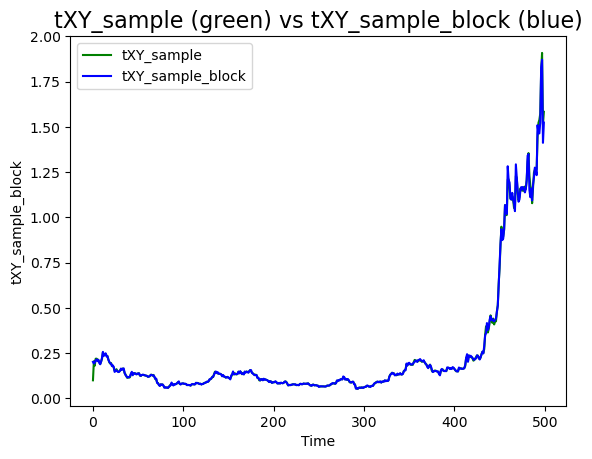

- We also tried the vairous models such as LSTM and GRU, with different structures. We should have fine tuned the model but were restricted by the time and computational resources.


- Based on textbook page 520, we removed the long-term trend before training and added it back so the prediction could be beneficial. Despite considering the removal of the long-term trend (1.3268730854582275e-06 per step), we encountered challenges such as negative close prices and NaN loss in the model. While we lack the time for an in-depth investigation, this area remains open for exploration.

- We need to fine-tune the model for optimal performance, but due to limited computational resources and time, comprehensive testing and tuning haven't done properly.

In [ ]:
K, (N, p), Nx, Ny = 50, tXY.shape, num_train-100, num_pred  # samples, dataset dim, train set size, forecast set size

LtX, LtY = [], []
for i in range(N - Ny - K, N - Ny):                         # populate K samples with past X series and future Y series
  LtX.append(tXY.iloc[(i - Nx):i, :].values)                # X: historical 7Dim observations for Nx steps behind
  LtY.append(tXY.loc[i:(i + Ny - 1),'Close'].values)        # Y: future closing prices for Ny steps ahead

taX, taY = np.array(LtX), np.array(LtY)                     # training arrays past input X and future output Y
print(f'taX.shape=(K, Nx, p)={taX.shape}; taY=(K, Ny)={taY.shape}; train set size={num_train - 100}')  # convert to 3-tensors

# df = pd.DataFrame(np.r_[taX[0,:,0], taY[0,:]], columns=['train train price'])
# ax = df.plot(figsize=(30,3), title=f'Training series (before and after)- just a closing price series (out of K={K})');
# pd.DataFrame(taX[0,:,0], columns=['train past price']).plot(grid=True, ax=ax);

taX.shape=(K, Nx, p)=(50, 400, 13); taY=(K, Ny)=(50, 26); train set size=400


Build a GRU model with 2 hidden layers 2 dropout layers with a 0.2 dropout rate.


In [ ]:
%%time
from tensorflow.keras.layers import GRU

# Initiation
tf.random.set_seed(0)   # always seed your experiments
Init = keras.initializers.GlorotUniform(seed=0) # seed all that you can
EPOCHS = 100

# Set Learning Rate function
def lr_scheduler(epoch, lr):
    if epoch in [EPOCHS // 2, EPOCHS // (4/3)]:
        lr *= 0.1
    return lr

lr_sched = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

# Initiate the model
m = Sequential(
    [GRU(500, return_sequences=True, input_shape=[None, p], name='GRU1',
         kernel_initializer=Init, recurrent_initializer=Init),
     Dropout(.2, name='d1'),
     GRU(500, name='GRU2', kernel_initializer=Init, recurrent_initializer=Init),
     Dropout(.2, name='d2'),
     Dense(Ny, name='out', kernel_initializer=Init)
    ], name='GRU_model') # we build Ny forecasts
m.summary()

m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
          loss='mean_squared_error')

# Training
hist = m.fit(taX, taY,
             epochs=EPOCHS, batch_size=1,
             callbacks=[lr_sched, es])

Model: "GRU_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU1 (GRU)                  (None, None, 500)         772500    
                                                                 
 d1 (Dropout)                (None, None, 500)         0         
                                                                 
 GRU2 (GRU)                  (None, 500)               1503000   
                                                                 
 d2 (Dropout)                (None, 500)               0         
                                                                 
 out (Dense)                 (None, 26)                13026     
                                                                 
Total params: 2288526 (8.73 MB)
Trainable params: 2288526 (8.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
50/50 [

tX_recent.shape=(Nx, p)=(400, 13)
1/1 [==============================] - 1s 548ms/step


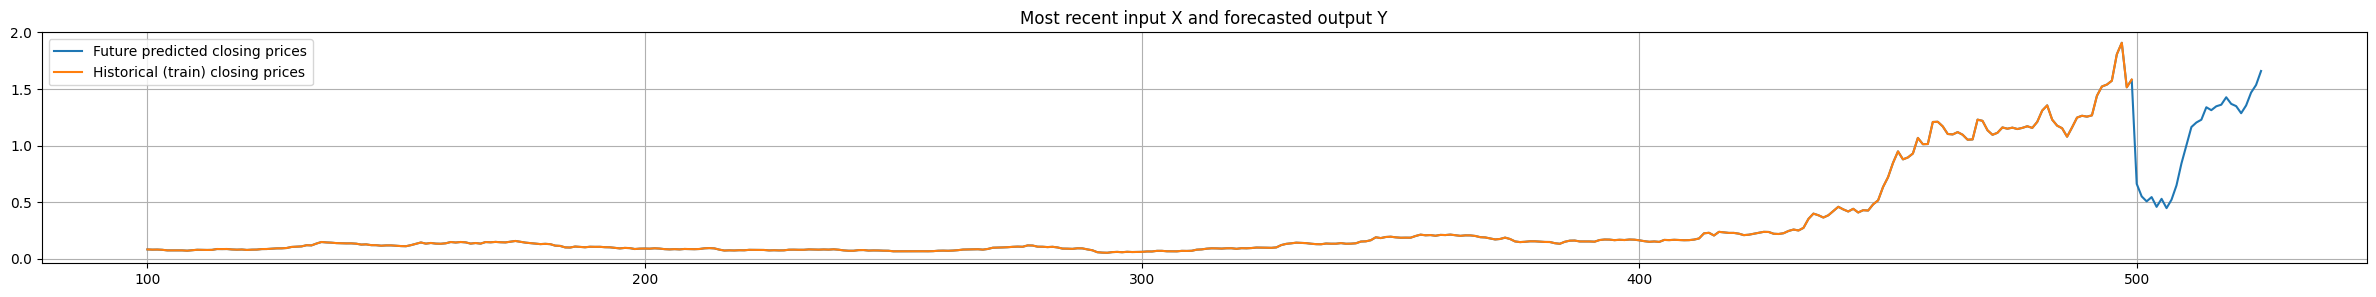

In [ ]:
tX_recent = tXY.iloc[-Nx:,:]  # most recent history of the coin
print(f'tX_recent.shape=(Nx, p)={tX_recent.shape}')
pY_dense['Close'] = m.predict(tX_recent.values[np.newaxis, ...]).flatten()  # the model expects a 3-tensor (K=1,Nx,p)
pY_dense['Close'] = pY_dense['Close'] * (MAX - MIN) + MIN # inverse minmax scalar
tX_recent['Close'] = tX_recent['Close'] * (MAX - MIN) + MIN # inverse minmax scalar

ax = pd.concat([tX_recent.Close, pY_dense.Close]).plot(figsize=(30, 3), title='Most recent input X and forecasted output Y');
tX_recent.Close.plot(ax=ax, grid=True);
ax.legend(["Future predicted closing prices", "Historical (train) closing prices"]);

## V. Prediction and Expansion

In [ ]:
pY_expand = librosa.resample(pY_dense['Close'].to_numpy(), orig_sr=len(pY_dense), target_sr=num_pred * sample_length)
pY_expand = pd.DataFrame(pY_expand[:pred_length], columns=['Close'])
pY_expand.index += train_length
ToCSV(pY_expand, 'Crypto_Group10_Final')

# **References:**

[1] Géron, A. (2019). Hands-on machine learning with Scikit-learn, Keras, and Tensorflow: Concepts, tools, and techniques to build intelligent systems (2nd edition). O'Reilly Media.

[2] G-Research Crypto Forecasting: Use your ML expertise to predict real crypto market data <br>
URL: https://www.kaggle.com/competitions/g-research-crypto-forecasting/leaderboard

[3] G-Research Crypto Forecasting: 2nd place solution <br>
URL: https://www.kaggle.com/competitions/g-research-crypto-forecasting/discussion/323098

[4] G-Research Crypto Forecasting: 3rd place solution <br>
URL: https://www.kaggle.com/competitions/g-research-crypto-forecasting/discussion/323703

[5] Pearson correlation coefficient <br>
URL: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

[6] librosa.resample <br>
URL: https://librosa.org/doc/main/generated/librosa.resample.html

[7] Wolpert, D. H., & Macready, W. G. (1997). No free lunch theorems for optimization. IEEE transactions on evolutionary computation, 1(1), 67-82.

[8] Zou, J., Zhao, Q., Jiao, Y., Cao, H., Liu, Y., Yan, Q., ... & Shi, J. Q. (2022). Stock Market Prediction via Deep Learning Techniques: A Survey. arXiv preprint arXiv:2212.12717.

[9] Berthold, M. R., & Höppner, F. (2016). On clustering time series using euclidean distance and pearson correlation. arXiv preprint arXiv:1601.02213.

[10] Chen, G., Tang, B., Zeng, X., Zhou, P., Kang, P., & Long, H. (2022). Short-term wind speed forecasting based on long short-term memory and improved BP neural network. International Journal of Electrical Power & Energy Systems, 134, 107365.


<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 165 sec


# 💡**Starter Ideas**

1. Try different RNN architectures and hyperparameters
1. Try [correlation loss/metric](https://duckduckgo.com/?q=correlation+loss+in+tensorflow&ia=web) (or equivalent)
1. Try longer/shorter history. FYI: GPU may not fit all observations, but you could lower the precision or simplify DNN
1. Try forecasting returns (differences or log differences at different lags) instead of actual values. Returns might appear "more" stationary (You'll need to compute forecasted prices from forecasted returns later)
1. Try new features: differences, fractions, powers of existing features, lagged features or lagged differences,..
1. Try a different time scale. Eg. forecasting every $k$ steps and then imputing interim values
1. Try technique in HOML pp.509-510
1. Try (programmatically) assigning higher/lower weights to history or historical events (such as extreme events)
1. Check [Kaggle G-Research Crypto Forecasting](https://www.kaggle.com/c/g-research-crypto-forecasting/code) competition for more suitable ideas.
1. Try further smoothing/averaging and forecasting values at sparser intervals
1. Try forecasting just the future trend